# Random Forrest and XGBoost

In [454]:
import os.path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier

## Data load and preparation

- Data processing step are based on findings during EDA
- Label encoding on categorical data

In [384]:
def get_processed_data(filename, encoder=None, split_target=True, oversample=False):  
    """Returns processed data for modeling

    Args:
        filename (string): The name of the data file
        encoder (LabelEncoder, optional): Fitted label encoder. Creates and fit a new one if None
        split_target (bool, optional): Set to True if file contains target data. Defaults to True
        oversample (bool, optional): Oversamples the minority class if True

    Returns:
        Pandas data frame(s): Processed data
        OrdinalEncoder: Fitted encoder if None was given
    """
    
    # determine file type
    extension = os.path.splitext(filename)[1][1:]
    
    # load all data
    if extension == 'xlsx':
        data = pd.read_excel(filename)
    elif extension == 'csv':
        data = pd.read_csv(filename)
    else:
        print(f'Error: Data file type "{extension}" is not supported!')
        return
    
    print(f'Loaded data shape: {data.shape}')
        
    # drop duplicates
    data.drop_duplicates(inplace=True, ignore_index=True)
    print(f'Shape w/o duplicates: {data.shape}')
    
    if split_target:
        predictors = data.iloc[:, 0:-1]
        target = data.iloc[:,-1:]
        
        if oversample:
            predictors, target = perform_oversampling(predictors, target)
    else:
        predictors = data
        
    # create ordinal encoder, if necessary
    categories = predictors.select_dtypes('object')
    if encoder == None:
        encoder = OrdinalEncoder()
        encoder.fit(categories)  
        
    ordinal_cats = encoder.transform(categories)
    
    encoded_predictors = pd.concat([predictors.select_dtypes(exclude='object'),
                                     pd.DataFrame(columns=encoder.feature_names_in_, data=ordinal_cats)],
                                    axis=1)
    
    print(f'Encoded data shape: {encoded_predictors.shape}')

    if split_target:
        # convert target yes/no to 0/1
        encoded_target = target.applymap(lambda x: 1 if x == 'yes' else 0)
        return encoded_predictors, encoded_target, encoder
    else:
        return encoded_predictors

## Metric

As discovered during EDA, we face an imbalanced classification problem, and therefore, using the right metric for model training is crucial.

F1 score is considered to be a good metric to measure the classification performance in this case.

## Training

### Split data for training and evaluation

In [385]:
# note: stratified target split due to imbalanced target data

predictors, target, train_encoder = get_processed_data('train_file.xlsx')

x_train, x_val, y_train, y_val = train_test_split(predictors, target,
                                                  train_size=0.8,
                                                  shuffle=True,
                                                  random_state=42,
                                                  stratify=target)

print(f'X train shape: {x_train.shape}; X test shape {x_val.shape}')
print(f'Y train shape: {y_train.shape}; Y test shape {y_val.shape}')

Loaded data shape: (32910, 15)
Shape w/o duplicates: (32902, 15)
Encoded data shape: (32902, 14)
X train shape: (26321, 14); X test shape (6581, 14)
Y train shape: (26321, 1); Y test shape (6581, 1)


In [338]:
x_train.head()

,age,duration,campaign,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
26760,27,237,2,4,8.0,2.0,6.0,0.0,0.0,2.0,0.0,4.0,1.0,2.0
4974,34,229,3,0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0
28345,35,96,1,0,0.0,1.0,6.0,0.0,0.0,2.0,0.0,1.0,2.0,1.0
19049,54,74,1,0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,6.0,2.0,1.0
10525,59,378,4,0,9.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0


### Compute class weight to handle imbalanced data

In [275]:
class_counts = target.value_counts()
class_weight = class_counts[0] / class_counts[1]
class_weight

7.875640679794983

### Random Forrest

#### Baseline

In [302]:
def print_train_val_metrics(model):
    """Prints metrics for training and evaluation data

    Args:
        model : The model to evaluate
    """
    
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    
    metric_results = pd.DataFrame(columns=['Training', 'Validation'], index=['Accuracy', 'F1 score', 'ROC AUC'])
    
    metric_results.at['Accuracy', 'Training'] = metrics.accuracy_score(y_train_pred, y_train)
    metric_results.at['F1 score', 'Training'] = metrics.f1_score(y_train_pred, y_train)
    metric_results.at['ROC AUC', 'Training'] = metrics.roc_auc_score(y_train_pred, y_train)
    
    metric_results.at['Accuracy', 'Validation'] = metrics.accuracy_score(y_val_pred, y_val)
    metric_results.at['F1 score', 'Validation'] = metrics.f1_score(y_val_pred, y_val)
    metric_results.at['ROC AUC', 'Validation'] = metrics.roc_auc_score(y_val_pred, y_val)
    
    print(metric_results.astype(float).round(3))

In [386]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train, y_train.values.ravel())
print_train_val_metrics(rf_classifier)

          Training  Validation
Accuracy       1.0       0.905
F1 score       1.0       0.479
ROC AUC        1.0       0.779


#### Class weight

In [387]:
rf_classifier_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_classifier_balanced.fit(x_train, y_train.values.ravel())
print_train_val_metrics(rf_classifier_balanced)

          Training  Validation
Accuracy       1.0       0.904
F1 score       1.0       0.433
ROC AUC        1.0       0.785


##### Feature importance

In [93]:
def print_feature_importance(features, importance_scores):
    feature_importance = pd.Series(importance_scores, index=features).sort_values(ascending=False)
    sns.barplot(x=feature_importance, y=feature_importance.index)
    plt.title('Feature importance scores')
    plt.xlabel('Feature')
    plt.ylabel('Score')
    plt.show()

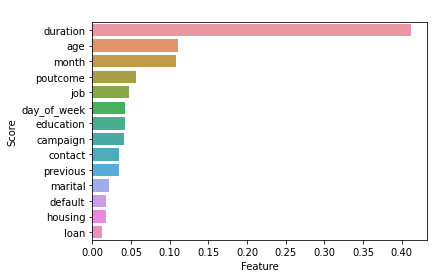

In [390]:
print_feature_importance(x_train.columns, rf_classifier_balanced.feature_importances_)

#### Hyperparameter tuning via grid search

In [424]:
rf_grid_parameters = [{'n_estimators' : [10, 20, 50, 100, 200],
                       'max_depth' : [4, 5, 6, 10, None],
                       'min_samples_split': [2, 4, 10, 20, 40, 100],
                       'max_features': [0.5, 'auto','sqrt','log2', None],
                       'bootstrap': [False, True],
                       'class_weight': ['balanced', 'balanced_subsample', None]}]

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid=rf_grid_parameters,
                              scoring='f1',
                              n_jobs=-1)

rf_classifier_grid = rf_grid_search.fit(x_train, y_train.values.ravel())
print(rf_classifier_grid.best_params_)

{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 0.5, 'min_samples_split': 20, 'n_estimators': 200}


In [425]:
print_train_val_metrics(rf_classifier_grid)

          Training  Validation
Accuracy     0.930       0.886
F1 score     0.754       0.599
ROC AUC      0.809       0.731


##### Feature importance

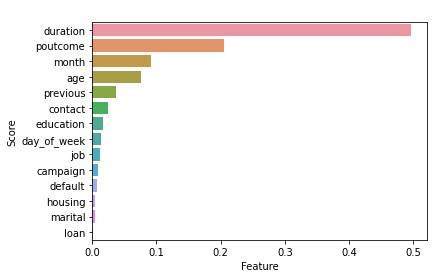

In [391]:
print_feature_importance(x_train.columns, rf_classifier_best_grid.feature_importances_)

### BalanceBaggingClassifier

In [393]:
bb_classifier = BalancedBaggingClassifier(random_state=42)
bb_classifier.fit(x_train, y_train.values.ravel())

print_train_val_metrics(bb_classifier)

          Training  Validation
Accuracy     0.907       0.861
F1 score     0.705       0.564
ROC AUC      0.774       0.704


### XGBoost

#### Baseline

In [394]:
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(x_train, y_train)

print_train_val_metrics(xgb_classifier)

          Training  Validation
Accuracy     0.955       0.908
F1 score     0.774       0.533
ROC AUC      0.926       0.779


#### Class weight

In [395]:
xgb_classifier_scaled = XGBClassifier(scale_pos_weight=class_weight, random_state=42)
xgb_classifier_scaled.fit(x_train, y_train)

print_train_val_metrics(xgb_classifier_scaled)

          Training  Validation
Accuracy     0.914       0.871
F1 score     0.717       0.586
ROC AUC      0.782       0.716


RandomizedSearchCV

In [409]:
xgb_grid_params = {
    'gamma': [0.05, 0.1,1],
    'max_depth': [5, 10, 20],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0.001, 0.01, 0.05],
    'scale_pos_weight': [1, class_weight]
}

xgb_classifier_grid = GridSearchCV(XGBClassifier(objective='binary:logistic',
                                                 random_state=42),
                                  param_grid=xgb_grid_params,
                                  scoring='f1',
                                  n_jobs=-1)

xgb_fitted_grid = xgb_classifier_grid.fit(x_train, y_train.values.ravel())

print(xgb_fitted_grid.best_params_)

{'alpha': 0.5, 'gamma': 0.05, 'lambda': 0.001, 'max_depth': 5, 'scale_pos_weight': 7.875640679794983}


In [411]:
print_train_val_metrics(xgb_fitted_grid)

          Training  Validation
Accuracy     0.897       0.864
F1 score     0.676       0.577
ROC AUC      0.759       0.709


##### Feature importance via SHAP values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


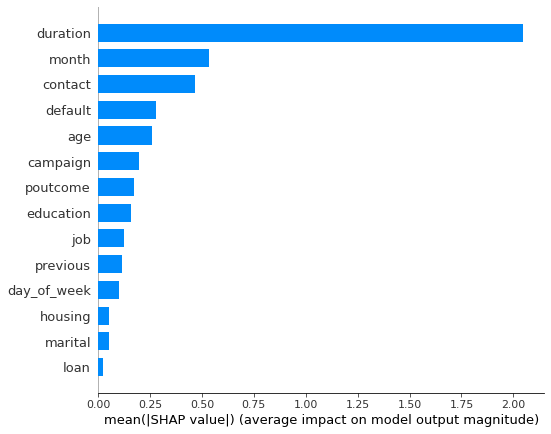

In [396]:
explainer = shap.Explainer(xgb_classifier)
shap_values = explainer(x_train)

shap.summary_plot(shap_values, x_train, plot_type="bar")

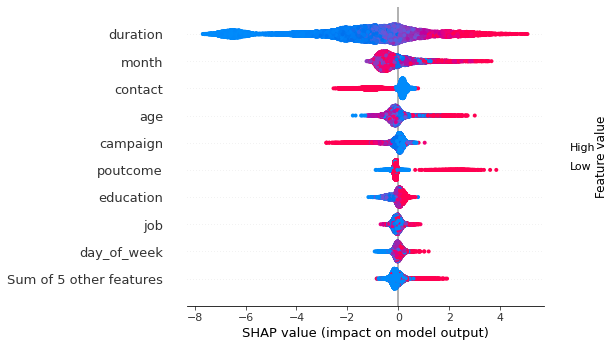

In [17]:
shap.plots.beeswarm(shap_values)

### Oversampling

In [401]:
def perform_oversampling(x, y):
    """Performs oversampling on the minority class "yes" in the target

    Args:
        x (DataFrame): Predictors
        y (DataFrame): Target

    Returns:
        DataFrames: Perdictors and the oversampled target data
    """
    print('Orig target balance:')
    print(y.y.value_counts())
    
    ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    x, y = ros.fit_resample(x, y)
    
    print('Resampled target balance:')
    print(y.y.value_counts())
    
    return x, y

In [400]:
predictors_os, target_os, train_encoder_os = get_processed_data('train_file.xlsx', oversample=True)

x_train_os, x_val_os, y_train_os, y_val_os = train_test_split(predictors_os, target_os,
                                                              train_size=0.8,
                                                              shuffle=True,
                                                              random_state=42,
                                                              stratify=target_os)

print(f'X train shape: {x_train_os.shape}; X test shape {x_val_os.shape}')
print(f'Y train shape: {y_train_os.shape}; Y test shape {y_val_os.shape}')

Loaded data shape: (32910, 15)
Shape w/o duplicates: (32902, 15)
Orig target balance:
no     29195
yes     3707
Name: y, dtype: int64
Resampled target balance:
no     29195
yes    29195
Name: y, dtype: int64
Encoded data shape: (58390, 14)
X train shape: (46712, 14); X test shape (11678, 14)
Y train shape: (46712, 1); Y test shape (11678, 1)


In [459]:
def print_train_val_metrics_os(model):
    """Prints metrics for training and evaluation of oversampled data

    Args:
        model : The model to evaluate
    """
    
    y_train_pred = model.predict(x_train_os)
    y_val_pred = model.predict(x_val_os)
    
    metric_results = pd.DataFrame(columns=['Training', 'Validation'], index=['Accuracy', 'F1 score', 'ROC AUC'])
    
    metric_results.at['Accuracy', 'Training'] = metrics.accuracy_score(y_train_pred, y_train_os)
    metric_results.at['F1 score', 'Training'] = metrics.f1_score(y_train_pred, y_train_os)
    metric_results.at['ROC AUC', 'Training'] = metrics.roc_auc_score(y_train_pred, y_train_os)
    
    metric_results.at['Accuracy', 'Validation'] = metrics.accuracy_score(y_val_pred, y_val_os)
    metric_results.at['F1 score', 'Validation'] = metrics.f1_score(y_val_pred, y_val_os)
    metric_results.at['ROC AUC', 'Validation'] = metrics.roc_auc_score(y_val_pred, y_val_os)
    
    print(metric_results.astype(float).round(3))

#### Random forest

In [426]:
rf_classifier_grid_os = GridSearchCV(RandomForestClassifier(random_state=42),
                                     param_grid=rf_grid_parameters,
                                     scoring='f1',
                                     n_jobs=-1,
                                     verbose=1)

rf_best_grid_os = rf_classifier_grid_os.fit(x_train_os, y_train_os.values.ravel())
print(rf_best_grid_os.best_params_)

Fitting 5 folds for each of 4500 candidates, totalling 22500 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 10}


In [462]:
print_train_val_metrics(rf_best_grid_os)

          Training  Validation
Accuracy     1.000       0.968
F1 score     0.999       0.876
ROC AUC      1.000       0.890


#### XGBoost

In [413]:
xgb_classifier_grid_os = GridSearchCV(XGBClassifier(objective='binary:logistic',
                                                    random_state=42),
                                      param_grid=xgb_grid_params,
                                      scoring='f1',
                                      n_jobs=-1,
                                      verbose=0)

xgb_best_grid_os = xgb_classifier_grid_os.fit(x_train_os, y_train_os.values.ravel())
print(xgb_best_grid_os.best_params_)

{'alpha': 0.1, 'gamma': 0.05, 'lambda': 0.05, 'max_depth': 20, 'scale_pos_weight': 1}


In [464]:
print_train_val_metrics(xgb_best_grid_os)

          Training  Validation
Accuracy       1.0       0.940
F1 score       1.0       0.788
ROC AUC        1.0       0.825


## Summary

| Model | AUC | F1 score |
| :--- | :---- | :---- |
| RF baseline |0.779|0.479*|
| RF class weight |0.785|0.433*|
| RF best grid |0.731|0.599|
| RF oversampling |0.890|0.876|
| Balance Bagging |0.704|0.564|
| XGB baseline |0.779|0.533*|
| XGB class weight |0.716|0.586|
| XGB best grid |0.709|0.577|
| XGB oversampling |0.825|0.788*|

* Overfitting

## Test predictions

### Load test data

In [357]:
# process test data
# use the encoder fitted to the training data
x_test = get_processed_data('test_file.xlsx', encoder=train_encoder, split_target=False)
x_test.head()

Loaded data shape: (40, 14)
Shape w/o duplicates: (40, 14)
Encoded data shape: (40, 14)


,age,duration,campaign,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,34,214,4,0,7.0,1.0,3.0,0.0,0.0,0.0,1.0,6.0,2.0,1.0
1,29,190,1,0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0
2,35,152,2,0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
3,60,179,1,0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,3.0,0.0,1.0
4,45,105,2,0,4.0,1.0,6.0,0.0,0.0,0.0,1.0,6.0,4.0,1.0


### Generate predictions

In [407]:
rf_classifier_os.predict(x_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [363]:
rf_best_grid_os.predict(x_test)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [379]:
rf_best_grid_os.predict(x_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [441]:
xgb_classifier_os.predict(x_test)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Write to CSV file

In [420]:
pd.DataFrame(columns=['RF best', 'XGB best'], data=[]).to_csv('test_predictions.csv')

In [ ]:
xgb_best_grid_os.predict(x_test)